In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.drop(['target_sum'], axis='columns', inplace=True)
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [4]:
raw_df.describe()

,cl_id,MCC,currency,amount,target_flag
count,490513.000000,490513.000000,490513.000000,4.905130e+05,490513.000000
mean,4802.127361,5699.783822,810.601854,5.723594e+03,0.652588
std,2986.492835,662.933380,38.223123,7.703763e+04,0.476148
min,0.000000,742.000000,32.000000,4.000000e-02,0.000000
25%,2193.000000,5411.000000,810.000000,2.240000e+02,0.000000
50%,4576.000000,5661.000000,810.000000,6.240000e+02,1.000000
75%,7390.000000,5941.000000,810.000000,2.176000e+03,1.000000
max,10215.000000,9405.000000,986.000000,3.583500e+07,1.000000


## Посмотреть распределения признаков

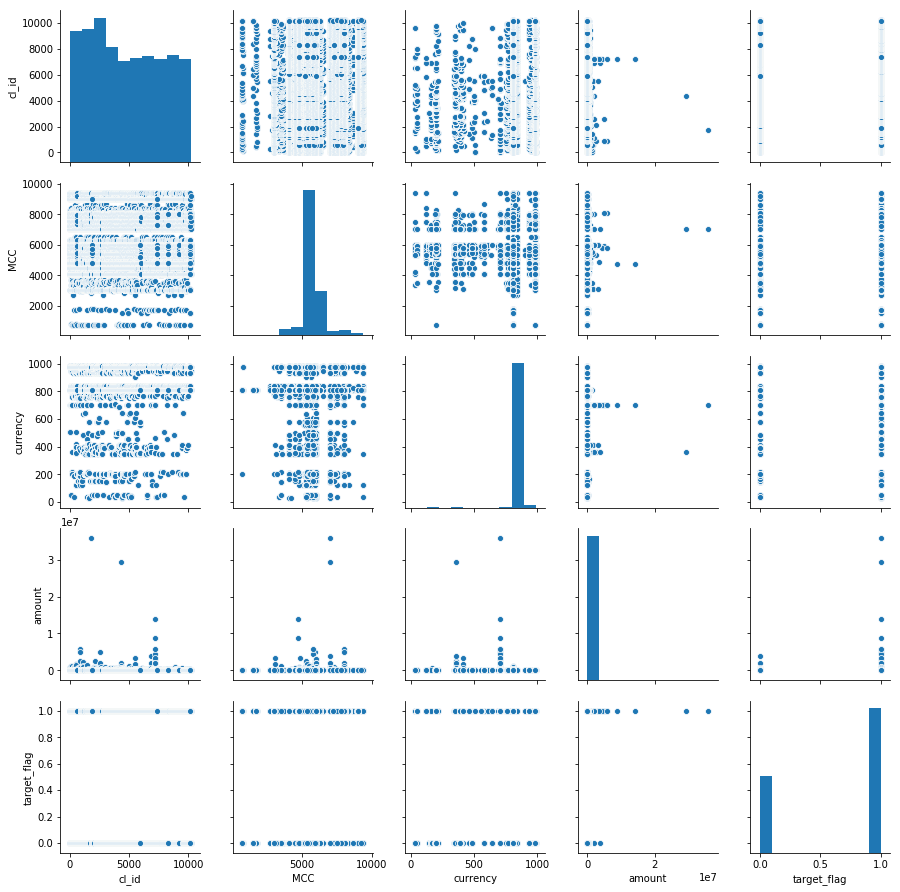

In [5]:
sns.pairplot(raw_df, kind='scatter')

C:\Users\Kabanov\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Kabanov\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Kabanov\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Kabanov\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


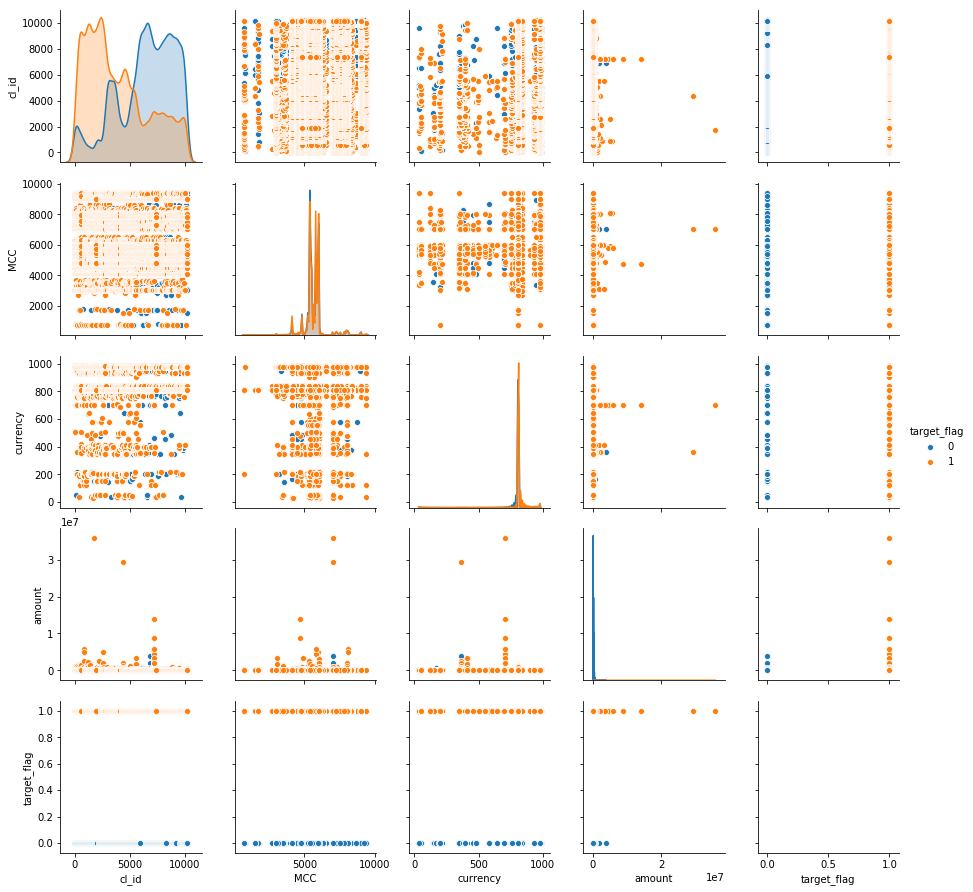

In [6]:
sns.pairplot(raw_df, hue='target_flag')

Из графиков распределения признаков можно сделать следующие выводы: 
* осталось клиентов больше, чем ушло
* клиенты, которые остались, в среднем тратили больше (значение amount больше)
* в целом размеры трат находятся в одном диапазоне
* в основном использовалась одна валюта
* в MCC выделяются несколько категорий
* наибольшие значения amount похожи на выбросы

## Выделить самые популярные MCC

In [5]:
mcc_codes_names = pd.read_csv('mcc_codes.csv.txt')
mcc_codes_names.columns = ['MCC', 'edited_description', 'combined_description', 'usda_description', 'irs_description', 'irs_reportable']
mcc_codes_names.head()

,MCC,edited_description,combined_description,usda_description,irs_description,irs_reportable
0,742,Veterinary Services,Veterinary Services,Veterinary Services,Veterinary Services,Yes
1,763,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Cooperative,Yes
2,780,"Horticultural Services, Landscaping Services","Horticultural Services, Landscaping Services",Horticultural Services,Landscaping Services,Yes
3,1520,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors,Yes
4,1711,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,"Heating, Plumbing, A/C",Yes


In [6]:
biggest_MCC = raw_df.groupby('MCC').agg({'target_flag': ['count', 'sum'], 'amount': 'sum'}).reset_index()
biggest_MCC.columns = ['MCC', 'target_flag_count', 'target_flag_sum', 'amount_sum']
biggest_MCC.sort_values('amount_sum', ascending=False).head()

,MCC,target_flag_count,target_flag_sum,amount_sum
244,6011,54382,35524,1.494000e+09
245,6012,10056,5709,1.849275e+08
158,5411,121640,75343,1.346700e+08
252,7011,2430,1767,9.442452e+07
119,4829,6205,3726,8.962841e+07


In [7]:
joined = biggest_MCC.merge(mcc_codes_names, on='MCC', how='left')
joined.drop(['combined_description', 'usda_description', 'irs_description', 'irs_reportable'], axis='columns', inplace=True)
joined.sort_values('amount_sum', ascending=False).head(10)

,MCC,target_flag_count,target_flag_sum,amount_sum,edited_description
244,6011,54382,35524,1.494000e+09,Financial Institutions – Manual Cash Disbursem...
245,6012,10056,5709,1.849275e+08,Financial Institutions – Merchandise and Services
158,5411,121640,75343,1.346700e+08,"Grocery Stores, Supermarkets"
252,7011,2430,1767,9.442452e+07,"Lodging – Hotels, Motels, Resorts, Central Res..."
119,4829,6205,3726,8.962841e+07,Money Orders – Wire Transfer
196,5812,30027,21741,5.341399e+07,Eating places and Restaurants
113,4722,781,494,4.277184e+07,Travel Agencies and Tour Operations
185,5712,2415,1382,3.108285e+07,"Furniture, Home Furnishings, and Equipment Sto..."
148,5211,6262,3668,3.059799e+07,Lumber and Building Materials Stores
111,4511,1647,1177,2.875367e+07,"Airlines, Air Carriers ( not listed elsewhere)"


In [8]:
len(biggest_MCC) == len(joined)

True

In [9]:
def MCC_percent(row):
    return row['amount_sum']/raw_df['amount'].sum()
def MCC_influence(row):
    return row['target_flag_sum']/row['target_flag_count']

In [10]:
joined['MCC_percent'] = joined.apply(MCC_percent, axis=1)
joined['MCC_influence'] = joined.apply(MCC_influence, axis=1)
print(len(joined['MCC'].unique()))
joined.sort_values('amount_sum', ascending=False).head(21)

344


,MCC,target_flag_count,target_flag_sum,amount_sum,edited_description,MCC_percent,MCC_influence
244,6011,54382,35524,1.494000e+09,Financial Institutions – Manual Cash Disbursem...,0.532146,0.653231
245,6012,10056,5709,1.849275e+08,Financial Institutions – Merchandise and Services,0.065869,0.567721
158,5411,121640,75343,1.346700e+08,"Grocery Stores, Supermarkets",0.047968,0.619393
252,7011,2430,1767,9.442452e+07,"Lodging – Hotels, Motels, Resorts, Central Res...",0.033633,0.727160
119,4829,6205,3726,8.962841e+07,Money Orders – Wire Transfer,0.031925,0.600483
196,5812,30027,21741,5.341399e+07,Eating places and Restaurants,0.019025,0.724048
113,4722,781,494,4.277184e+07,Travel Agencies and Tour Operations,0.015235,0.632522
185,5712,2415,1382,3.108285e+07,"Furniture, Home Furnishings, and Equipment Sto...",0.011071,0.572257
148,5211,6262,3668,3.059799e+07,Lumber and Building Materials Stores,0.010899,0.585755
111,4511,1647,1177,2.875367e+07,"Airlines, Air Carriers ( not listed elsewhere)",0.010242,0.714633


Самый популярный MCC код 6011 (снятие наличности автоматически), его доля в общей величине расходов 53%. Следующие по величине 20 кодов дают 33% суммарно, 30 кодов - 37,6%. Можно посмотреть распределение долей крупнейших MCC на графике. Остальные 313 MCC суммарно дают 9%.

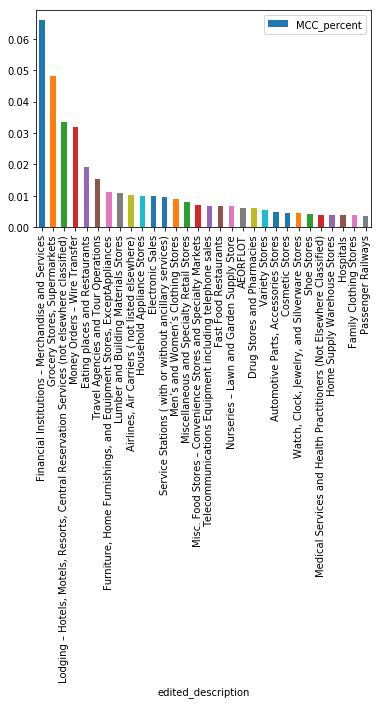

In [12]:
joined.sort_values('amount_sum', ascending=False).iloc[1:31].plot(x='edited_description', y='MCC_percent', kind='bar')

## Помотреть активность клиентов по дням недели/времени

In [13]:
def day_number(row):
    return datetime.datetime.strptime(row['TRDATETIME'], '%d%b%y:%H:%M:%S').strftime('%w')

In [14]:
raw_df['day_number'] = raw_df.apply(day_number, axis=1)
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,day_number
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,6
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,4
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,2
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,6
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,2


In [15]:
amount_by_day_number = raw_df.groupby('day_number').agg({'target_flag': ['count', 'sum'], 'amount': 'sum'}).reset_index()
amount_by_day_number.columns = ['day_number', 'target_flag_count', 'target_flag_sum', 'amount_sum']
amount_by_day_number['target_flag_share'] = amount_by_day_number.apply(lambda x: x['target_flag_sum']/x['target_flag_count'], axis=1)
amount_by_day_number

,day_number,target_flag_count,target_flag_sum,amount_sum,target_flag_share
0,0,62114,40916,2.626989e+08,0.658724
1,1,65927,42858,3.986560e+08,0.650083
2,2,68509,44483,4.098528e+08,0.649302
3,3,69485,45372,4.532207e+08,0.652975
4,4,71458,46451,4.464912e+08,0.650046
5,5,78993,51579,4.889552e+08,0.652957
6,6,74027,48444,3.476228e+08,0.654410


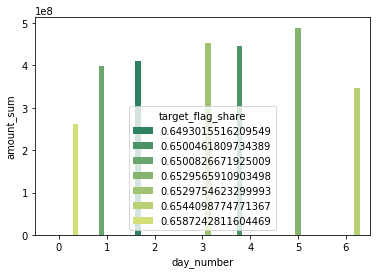

In [16]:
sns.barplot(x='day_number', y='amount_sum',data=amount_by_day_number,hue='target_flag_share',palette='summer')

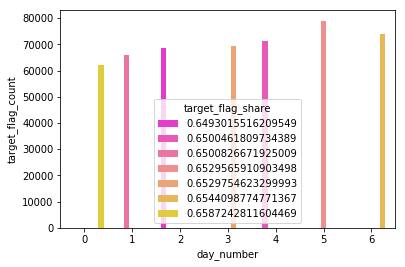

In [17]:
sns.barplot(x='day_number', y='target_flag_count',data=amount_by_day_number, hue='target_flag_share',palette='spring')

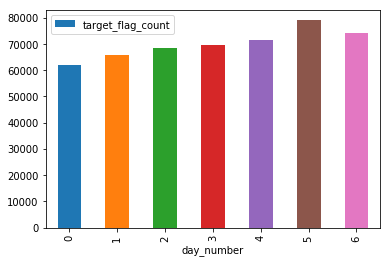

In [18]:
amount_by_day_number.plot(x='day_number', y='target_flag_count', kind='bar')

В целом активность клиентов по сумме трат растет с понедельника, достигает максимума в пятницу, потом падает в субботу и достигает минимума в воскресенье. Количество транзакций меняется аналогично, однако более сглажено.

In [19]:
def hour_of_transaction(row):
    return datetime.datetime.strptime(row['TRDATETIME'], '%d%b%y:%H:%M:%S').strftime('%H')

In [20]:
raw_df['hour_of_transaction'] = raw_df.apply(hour_of_transaction, axis=1)
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,day_number,hour_of_transaction
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,6,00
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,4,12
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,2,00
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,6,00
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,2,13


In [21]:
amount_by_hour_number = raw_df.groupby('hour_of_transaction').agg({'target_flag': ['count', 'sum'], 'amount': 'sum'}).reset_index()
amount_by_hour_number.columns = ['hour_of_transaction', 'target_flag_count', 'target_flag_sum', 'amount_sum']
amount_by_hour_number['target_flag_share'] = amount_by_hour_number.apply(lambda x: x['target_flag_sum']/x['target_flag_count'], axis=1)
amount_by_hour_number

,hour_of_transaction,target_flag_count,target_flag_sum,amount_sum,target_flag_share
0,00,432913,284776,1.486147e+09,0.657813
1,01,252,184,3.543151e+06,0.730159
2,02,350,270,8.535024e+06,0.771429
3,03,456,347,1.061901e+07,0.760965
4,04,660,464,1.526562e+07,0.703030
5,05,981,671,2.326990e+07,0.683996
6,06,1315,837,3.096366e+07,0.636502
7,07,1983,1261,4.350872e+07,0.635905
8,08,2699,1659,5.891576e+07,0.614672
9,09,3635,2270,7.996349e+07,0.624484


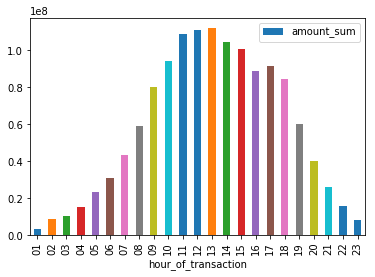

In [22]:
amount_by_hour_number.iloc[1:24].plot(x='hour_of_transaction', y='amount_sum', kind='bar')

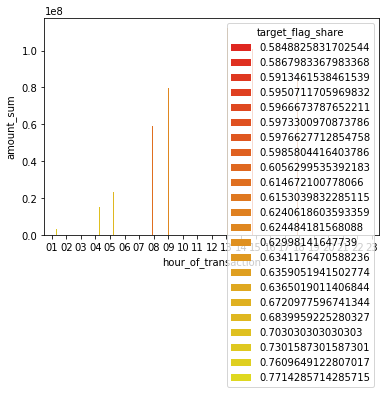

In [34]:
sns.barplot(x='hour_of_transaction', y='amount_sum',data=amount_by_hour_number.iloc[1:24],hue='target_flag_share',palette='autumn')

Графики показывают, что лояльность клиента практически не зависит от дня недели, в который совершаются покупки, однако она взаимосвязана со временем транзакции: клиеты, которые пользовались продуктом в ночное время с 1 до 5 утра, с большей вероятностью продолжат им пользоваться.

## Какие категории транзакции (trx_category) наиболее популярны

In [25]:
biggest_trx_category = raw_df.groupby('trx_category').agg({'target_flag': ['count', 'sum'], 'amount': 'sum'}).reset_index()
biggest_trx_category.columns = ['trx_category', 'target_flag_count', 'target_flag_sum', 'amount_sum']
biggest_trx_category.sort_values('amount_sum', ascending=False)

,trx_category,target_flag_count,target_flag_sum,amount_sum
6,POS,416425,272997,1.013062e+09
9,WD_ATM_ROS,19104,13608,6.680845e+08
5,DEPOSIT,21216,9900,4.827459e+08
8,WD_ATM_PARTNER,9948,7095,3.327178e+08
1,C2C_IN,7306,3965,9.989715e+07
2,C2C_OUT,5456,3670,8.807488e+07
7,WD_ATM_OTHER,7140,6369,7.478062e+07
0,BACK_TRX,2687,1584,2.461917e+07
4,CAT,1197,897,2.260286e+07
3,CASH_ADV,34,18,9.128249e+05


In [27]:
def trx_category_percent(row):
    return row['amount_sum']/raw_df['amount'].sum()
def trx_category_influence(row):
    return row['target_flag_sum']/row['target_flag_count']

In [28]:
biggest_trx_category['trx_category_percent'] = biggest_trx_category.apply(trx_category_percent, axis=1)
biggest_trx_category['trx_category_influence'] = biggest_trx_category.apply(trx_category_influence, axis=1)
print(len(biggest_trx_category['trx_category'].unique()))
biggest_trx_category.sort_values('amount_sum', ascending=False)

10


,trx_category,target_flag_count,target_flag_sum,amount_sum,trx_category_percent,trx_category_influence
6,POS,416425,272997,1.013062e+09,0.360842,0.655573
9,WD_ATM_ROS,19104,13608,6.680845e+08,0.237964,0.712312
5,DEPOSIT,21216,9900,4.827459e+08,0.171949,0.466629
8,WD_ATM_PARTNER,9948,7095,3.327178e+08,0.118510,0.713209
1,C2C_IN,7306,3965,9.989715e+07,0.035582,0.542705
2,C2C_OUT,5456,3670,8.807488e+07,0.031371,0.672654
7,WD_ATM_OTHER,7140,6369,7.478062e+07,0.026636,0.892017
0,BACK_TRX,2687,1584,2.461917e+07,0.008769,0.589505
4,CAT,1197,897,2.260286e+07,0.008051,0.749373
3,CASH_ADV,34,18,9.128249e+05,0.000325,0.529412


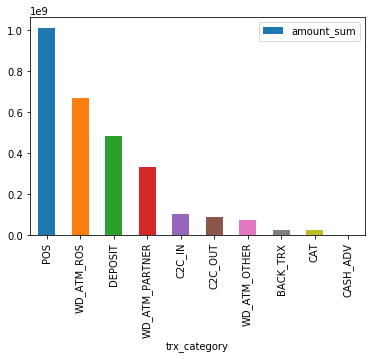

In [31]:
biggest_trx_category.sort_values('amount_sum', ascending=False).plot(x='trx_category', y='amount_sum', kind='bar')

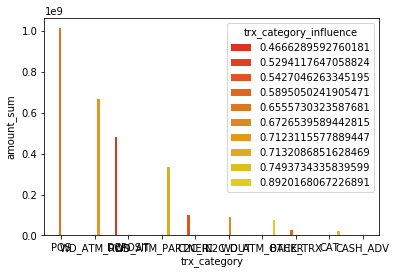

In [32]:
sns.barplot(x='trx_category', y='amount_sum',data=biggest_trx_category.sort_values('amount_sum', ascending=False),hue='trx_category_influence',palette='autumn')

Отслеживается небольшая взаимосвязь между лояльностью клиента и использованием WD_ATM_OTHER	, вместе с тем доля этой категории в общей величине расходов мала (2,7%)

## Выделить самые популярные валюты

In [36]:
currency_list = raw_df.groupby('currency').agg({'target_flag': ['count', 'sum'], 'amount': 'sum'}).reset_index()
currency_list.columns = ['currency', 'target_flag_count', 'target_flag_sum', 'amount_sum']
print(len(raw_df.currency.unique()))
currency_list.sort_values('amount_sum', ascending=False).head(20)

59


,currency,target_flag_count,target_flag_sum,amount_sum
44,810,477644,311225,2.572996e+09
37,704,52,51,1.367180e+08
17,360,72,66,7.193555e+07
21,410,110,109,1.260942e+07
19,392,197,168,1.710582e+06
3,51,60,51,1.565529e+06
14,348,151,136,1.382239e+06
41,764,412,208,1.354299e+06
5,144,40,0,1.079799e+06
20,398,99,98,1.025721e+06


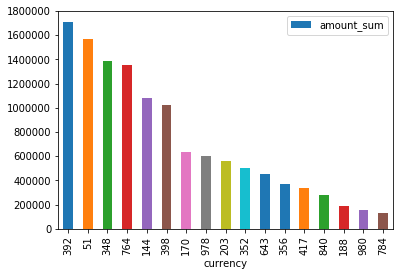

In [41]:
currency_list.sort_values('amount_sum', ascending=False).iloc[4:21].plot(x='currency', y='amount_sum', kind='bar')

Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [43]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [44]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  397797
Total transactions in test dataset:  92716


Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test

In [45]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [46]:
aggregated_df = get_aggregated_df(raw_df, 'sum', 'channel_type')
aggregated_df.head()

channel_type,channel_type_sum_type1,channel_type_sum_type2,channel_type_sum_type3,channel_type_sum_type4,channel_type_sum_type5
cl_id,,,,,
50,0.0,0.0,0.0,0.0,267108.91
52,0.0,0.0,0.0,0.0,514679.46
54,0.0,0.0,0.0,0.0,175289.16
55,0.0,0.0,0.0,0.0,352452.82
56,0.0,0.0,0.0,0.0,1106460.77
